# Lab — Travelling Salesman Problem solving via GNNs

In [2]:
#!git clone https://github.com/netspractice/learning-tsp .
!git init .
!git remote add origin https://github.com/netspractice/learning-tsp
!git pull origin master

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 138 (delta 17), reused 0 (delta 0), pack-reused 95
Receiving objects: 100% (138/138), 54.37 MiB | 34.92 MiB/s, done.
Resolving deltas: 100% (32/32), done.
From https://github.com/netspractice/learning-tsp
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [3]:
import requests
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from train import train_epoch, train_epoch_sl
from nets.nar_model import NARModel
from nets.encoders.gnn_encoder import GNNEncoder
from utils import torch_load_cpu, load_problem
import warnings
warnings.filterwarnings('ignore')

Traveling Salesman Problem (TSP):
> *Given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?*

TSP is NP-hard problem

<table>
<tr><th>n <th>brute force<th>Held-Karp algorithm
<tr><td>  <td>expected time &approx; O(n!)<td>expected time &approx; O(n<sup>2</sup> 2<sup>n</sup>)
<tr><td>10<td> 10! tours = 2 secs                <td>0.1 secs 
<tr><td>11<td>2 secs &times; 11! / 10! &approx; 22 secs  <td>0.2 secs
<tr><td>12<td>2 secs &times; 12! / 10! &approx; 4 mins   <td>0.4 secs
<tr><td>14<td>2 secs &times; 14! / 10! &approx; 13 hours <td>3 secs
<tr><td>16<td>2 secs &times; 16! / 10! &approx; 200 days <td> 16<sup>2</sup> 2<sup>16</sup> tours = 11 secs
<tr><td>18<td>2 secs &times; 18! / 10! &approx; 112 years
<td>11 secs &times; (18/16)<sup>2</sup> 2<sup>(18-16)</sup> &approx; 1 min
<tr><td>25<td>2 secs &times; 25! / 10! &approx; 270 billion years
<td> 11 secs &times; (25/16)<sup>2</sup> 2<sup>(25-16)</sup>  &approx; 4 hours
<tr><td>50<td>2 secs &times; 50! / 10! &approx; 5 &times; 10<sup>50</sup> years</a><td>11 secs &times;  (50/16)<sup>2</sup> 2<sup>(50-16)</sup> &approx; 58,000 years
</table>

source: http://www.math.uwaterloo.ca/tsp/index.html

### Heuristic solution

Generate the data

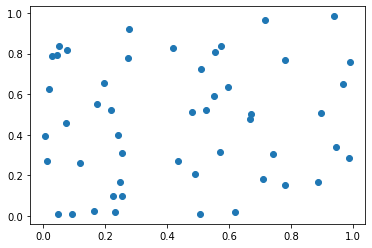

In [4]:
n_cities = 50
data = np.random.rand(n_cities, 2)
plt.scatter(data[:, 0], data[:, 1]);

Prepare distance matrix

In [5]:
dist_matrix = squareform(pdist(data))
dist_matrix[range(n_cities), range(n_cities)] = np.inf
pd.DataFrame(dist_matrix).iloc[:10, :10].round(2)

,0,1,2,3,4,5,6,7,8,9
0,inf,0.17,0.46,0.58,0.58,0.57,0.23,0.47,0.55,0.65
1,0.17,inf,0.61,0.51,0.71,0.51,0.23,0.64,0.72,0.78
2,0.46,0.61,inf,1.03,0.72,1.01,0.46,0.28,0.18,0.76
3,0.58,0.51,1.03,inf,0.70,0.05,0.73,0.93,1.07,0.76
4,0.58,0.71,0.72,0.70,inf,0.66,0.80,0.46,0.64,0.07
5,0.57,0.51,1.01,0.05,0.66,inf,0.74,0.90,1.05,0.72
6,0.23,0.23,0.46,0.73,0.80,0.74,inf,0.59,0.61,0.87
7,0.47,0.64,0.28,0.93,0.46,0.90,0.59,inf,0.18,0.49
8,0.55,0.72,0.18,1.07,0.64,1.05,0.61,0.18,inf,0.67
9,0.65,0.78,0.76,0.76,0.07,0.72,0.87,0.49,0.67,inf


A random tour

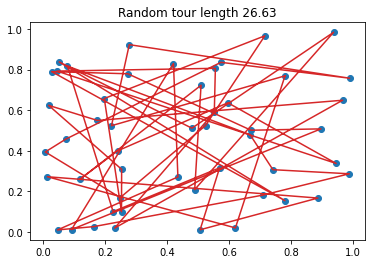

In [6]:
rtour = np.random.permutation(range(n_cities))
rtour = np.append(rtour, rtour[0])
row_id, col_id = rtour[:-1], rtour[1:]
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[rtour, 0], data[rtour, 1], c='tab:red')
plt.title(f'Random tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

2-OPT heuristic

In [7]:
def twoopt(dist_matrix, tour, n_iter):
    best_length = dist_matrix[tour[:-1], tour[1:]].sum()
    best_tour = tour.copy()
    for _ in range(n_iter):
        for i in range(1, len(tour) - 2):
            for j in range(i + 1, len(tour) - 1):
                new_tour = np.concatenate([
                    best_tour[0:i],
                    best_tour[j:-len(tour) + i - 1:-1],
                    best_tour[j + 1:len(tour)]
                ])
                new_length = dist_matrix[new_tour[:-1], new_tour[1:]].sum()
                if new_length < best_length:
                    best_tour = new_tour
                    best_length = new_length
    return best_tour[:-1], best_tour[1:]

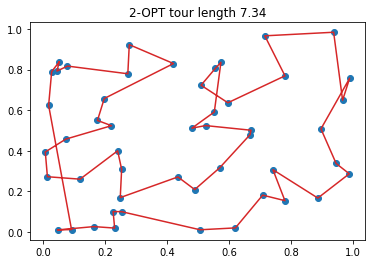

In [8]:
rtour = np.random.permutation(range(n_cities))
rtour = np.append(rtour, rtour[0])
row_id, col_id = twoopt(dist_matrix, rtour, n_iter=2)
tour = np.append(row_id, row_id[0])
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[tour, 0], data[tour, 1], c='tab:red')
plt.title(f'2-OPT tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

Nearest neighbor (NN) heuristic

In [9]:
def nn(dist_matrix):
    best_length = np.inf
    best_tour = None
    for start_city in range(dist_matrix.shape[0]):
        copy_cost = dist_matrix.copy()
        current_city = start_city
        copy_cost[:, current_city] = np.inf
        tour = [current_city]
        for _ in range(copy_cost.shape[0]-1):
            next_city = np.argmin(copy_cost[current_city])
            tour.append(next_city)
            copy_cost[:, next_city] = np.inf
            current_city = next_city
        tour = np.array(tour + [tour[0]])
        new_length = dist_matrix[tour[:-1], tour[1:]].sum()
        if new_length < best_length:
                    best_tour = tour
                    best_length = new_length
    return best_tour[:-1], best_tour[1:]

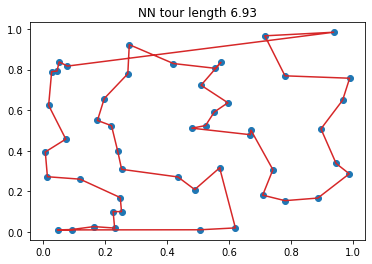

In [10]:
row_id, col_id = nn(dist_matrix)
tour = np.append(row_id, row_id[0])
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[tour, 0], data[tour, 1], c='tab:red')
plt.title(f'NN tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

Stochastic NN + 2-OPT heuristic 

In [11]:
def stochastic_nn_2opt(dist_matrix, n_iter):
    row_id, col_id = nn(dist_matrix)
    nntour = np.append(row_id, row_id[0])
    row_id, col_id = twoopt(dist_matrix, nntour, n_iter=n_iter)
    new_tour = np.append(row_id, row_id[0])
    return new_tour[:-1], new_tour[1:]

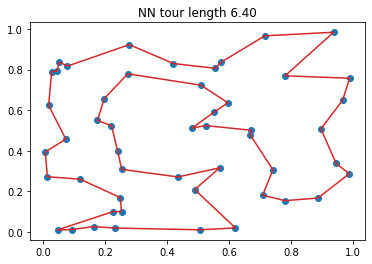

In [12]:
row_id, col_id = stochastic_nn_2opt(dist_matrix, n_iter=5)
tour = np.append(row_id, row_id[0])
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[tour, 0], data[tour, 1], c='tab:red')
plt.title(f'NN tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

There are other heuristics: Insertion Heuristic (IH), Minimum Spanning Tree completion, etc.

### GNN model

* original paper: https://arxiv.org/abs/2006.07054
* source code: https://github.com/chaitjo/learning-tsp

The idea is to generate many instances and train GNN model to predict edges in the tour. The first step is to prepare graph.

<img src='https://github.com/netspractice/advanced_gnn/raw/main/lab10_combinatorial_opt/gnn1.png' width=600>

Next, we create node embeddings

<img src='https://github.com/netspractice/advanced_gnn/raw/main/lab10_combinatorial_opt/gnn2.png' width=600>

Finally, we decode embeddings into probabilities of presence of an edge in the optimal tour and then search a tour using greed search or beam search.

<img src='https://github.com/netspractice/advanced_gnn/raw/main/lab10_combinatorial_opt/gnn3.png' width=600>

Encoder is defined as
$$
\begin{aligned}
h_{i}^{\ell+1} &=h_{i}^{\ell}+\operatorname{ReLU}\left(\operatorname{NORM}\left(U^{\ell} h_{i}^{\ell}+\operatorname{AGGR}_{j \in \mathcal{N}_{i}}\left(\sigma\left(e_{i j}^{\ell}\right) \odot V^{\ell} h_{j}^{\ell}\right)\right)\right) \\
e_{i j}^{\ell+1} &=e_{i j}^{\ell}+\operatorname{ReLU}\left(\operatorname{NORM}\left(A^{\ell} e_{i j}^{\ell}+B^{\ell} h_{i}^{\ell}+C^{\ell} h_{j}^{\ell}\right)\right)
\end{aligned}
$$

Decoder is defined as 
$$
\hat{p}_{i j}=W_{2}\left(\operatorname{ReLU}\left(W_{1}\left(\left[h_{G}, h_{i}^{L}, h_{j}^{L}\right]\right)\right)\right), \text { where } h_{G}=\frac{1}{n} \sum_{i=0}^{n} h_{i}^{L},
$$

Training is performed as in link prediction setting: minimization cross entropy between adjacency matrices.

Download dataset

In [13]:
url = 'https://github.com/netspractice/advanced_gnn/raw/main/lab10_combinatorial_opt/tsp20-50_train_concorde.txt'
open('data/tsp/tsp20-50_train_concorde.txt', 'wb').write(requests.get(url).content)
url = 'https://github.com/netspractice/advanced_gnn/raw/main/lab10_combinatorial_opt/tsp20_test_concorde.txt'
open('data/tsp/tsp20_test_concorde.txt', 'wb').write(requests.get(url).content)
url = 'https://github.com/netspractice/advanced_gnn/raw/main/lab10_combinatorial_opt/tsp50_test_concorde.txt'
open('data/tsp/tsp50_test_concorde.txt', 'wb').write(requests.get(url).content);

In [14]:
problem = load_problem('tspsl')
train_dataset = problem.make_dataset(
        filename='data/tsp/tsp20-50_train_concorde.txt', batch_size=128, num_samples=12800, 
        neighbors=0.2, knn_strat='percentage', supervised=True, nar=True
    )
val_datasets = []
for val_filename in ['data/tsp/tsp20_test_concorde.txt', 'data/tsp/tsp50_test_concorde.txt']:
    val_datasets.append(
        problem.make_dataset(
            filename=val_filename, batch_size=128, num_samples=1280, 
            neighbors=0.2, knn_strat='percentage', supervised=True, nar=False
        ))


Loading from data/tsp/tsp20-50_train_concorde.txt...


100%|##########| 12800/12800 [00:00<00:00, 13617.00it/s]



Loading from data/tsp/tsp20_test_concorde.txt...


100%|##########| 1280/1280 [00:00<00:00, 40135.38it/s]



Loading from data/tsp/tsp50_test_concorde.txt...


100%|##########| 1280/1280 [00:00<00:00, 4312.57it/s]


In [15]:
train_example = train_dataset[0]
train_example

{'nodes': tensor([[0.4977, 0.8178],
         [0.6121, 0.7714],
         [0.8607, 0.1506],
         [0.1985, 0.8152],
         [0.1588, 0.1161],
         [0.0129, 0.4868],
         [0.3310, 0.8026],
         [0.0983, 0.0560],
         [0.4427, 0.0221],
         [0.2907, 0.2464],
         [0.7383, 0.8892],
         [0.9871, 0.1174],
         [0.3938, 0.4527],
         [0.5381, 0.7906],
         [0.4658, 0.4353],
         [0.5695, 0.9693],
         [0.0406, 0.5481],
         [0.4626, 0.3765],
         [0.3279, 0.8135],
         [0.6466, 0.0474],
         [0.9950, 0.6892],
         [0.9295, 0.9181],
         [0.9753, 0.3970],
         [0.2626, 0.4302],
         [0.7645, 0.5997],
         [0.0809, 0.7045],
         [0.1640, 0.0323],
         [0.3282, 0.4739],
         [0.0681, 0.3827],
         [0.1186, 0.8963],
         [0.7643, 0.3754],
         [0.0258, 0.9065],
         [0.7864, 0.6193],
         [0.2116, 0.2923],
         [0.6615, 0.8863]]), 'graph': tensor([[1, 0, 1,  ..., 1, 1, 0],
 

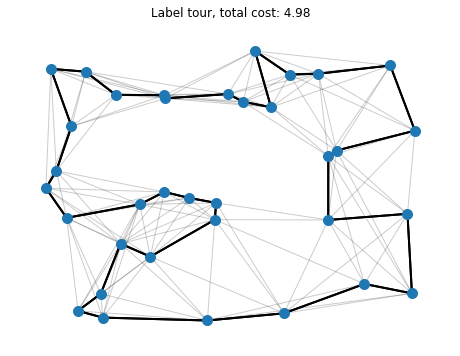

In [16]:
dist_matrix = squareform(pdist(train_example['nodes'].numpy()))
G = nx.from_numpy_array(1-train_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(train_example['nodes'])}
tour = train_example['tour_edges'].nonzero().numpy()
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=tour, )
tour = train_example['tour_nodes'].numpy()
tour = np.append(tour, tour[0])
cost = dist_matrix[tour[:-1], tour[1:]].sum()
plt.title(f'Label tour, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Define the model

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
model = NARModel(
    problem=problem,
    embedding_dim=128,
    encoder_class=GNNEncoder,
    n_encode_layers=2,
    aggregation='max',
    aggregation_graph='mean',
    normalization='batch',
)
model.to(device)

NARModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(2, 128)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_features=128, bias=True)
        (C): Linear(in_features=128, out_features=128, bias=True)
        (norm_h): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_features=1

In [23]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

Run the training

In [24]:
class option():
    def __init__(self):
        self.run_name = 'train'
        self.epoch_size = 12800
        self.batch_size = 128
        self.no_tensorboard = True
        self.num_workers = 1
        self.no_progress_bar = False
        self.device = device
        self.model = 'nar'
        self.accumulation_steps = 8
        self.max_grad_norm = 1
        self.log_step = 100
        self.checkpoint_epochs = 0
        self.n_epochs = 10
        self.save_dir = ""
opt = option()

for epoch in range(opt.n_epochs):
    train_epoch_sl(
        model,
        optimizer,
        optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0 ** epoch),
        epoch,
        train_dataset,
        val_datasets,
        problem,
        None,
        opt
    )


Start train epoch 0, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:12,  7.99it/s]


epoch: 0, train_batch_id: 0, loss: 0.10179367661476135, avg_cost: 0.0
grad_norm: 0.5270904302597046, clipped: 0.5270904302597046


100%|##########| 100/100 [00:09<00:00, 11.05it/s]


Finished epoch 0, took 00:00:09 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 30.29it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.788 +- 0.530
Validation optimality gap: 24.578% +- 10.959

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.60it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 8.271 +- 0.574
Validation optimality gap: 45.496% +- 9.130

Start train epoch 1, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:10,  9.32it/s]


epoch: 1, train_batch_id: 0, loss: 0.07172621041536331, avg_cost: 0.0
grad_norm: 0.0982172042131424, clipped: 0.0982172042131424


100%|##########| 100/100 [00:08<00:00, 11.25it/s]


Finished epoch 1, took 00:00:08 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 31.49it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.561 +- 0.487
Validation optimality gap: 18.581% +- 9.013

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.86it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.834 +- 0.535
Validation optimality gap: 37.778% +- 7.974

Start train epoch 2, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:14,  6.88it/s]


epoch: 2, train_batch_id: 0, loss: 0.06235751882195473, avg_cost: 0.0
grad_norm: 0.06918259710073471, clipped: 0.06918259710073471


100%|##########| 100/100 [00:08<00:00, 11.19it/s]


Finished epoch 2, took 00:00:08 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 31.98it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.415 +- 0.457
Validation optimality gap: 14.793% +- 8.086

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.75it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.516 +- 0.527
Validation optimality gap: 32.186% +- 7.877

Start train epoch 3, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:11,  8.57it/s]


epoch: 3, train_batch_id: 0, loss: 0.05725349858403206, avg_cost: 0.0
grad_norm: 0.06830741465091705, clipped: 0.06830741465091705


100%|##########| 100/100 [00:08<00:00, 11.15it/s]


Finished epoch 3, took 00:00:08 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 31.25it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.376 +- 0.450
Validation optimality gap: 13.777% +- 7.998

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.65it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.450 +- 0.543
Validation optimality gap: 30.996% +- 7.705

Start train epoch 4, lr=0.0005 for run train


  3%|3         | 3/100 [00:00<00:10,  9.63it/s]


epoch: 4, train_batch_id: 0, loss: 0.04935125634074211, avg_cost: 0.0
grad_norm: 0.033060017973184586, clipped: 0.033060017973184586


100%|##########| 100/100 [00:08<00:00, 11.19it/s]


Finished epoch 4, took 00:00:08 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 31.29it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.326 +- 0.441
Validation optimality gap: 12.465% +- 7.430

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.62it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.320 +- 0.503
Validation optimality gap: 28.729% +- 7.416

Start train epoch 5, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:10,  9.64it/s]


epoch: 5, train_batch_id: 0, loss: 0.05111058056354523, avg_cost: 0.0
grad_norm: 0.08973635733127594, clipped: 0.08973635733127594


100%|##########| 100/100 [00:08<00:00, 11.17it/s]


Finished epoch 5, took 00:00:08 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 32.20it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.314 +- 0.437
Validation optimality gap: 12.176% +- 7.777

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.61it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.221 +- 0.504
Validation optimality gap: 26.994% +- 7.442

Start train epoch 6, lr=0.0005 for run train


  3%|3         | 3/100 [00:00<00:10,  9.04it/s]


epoch: 6, train_batch_id: 0, loss: 0.04295835271477699, avg_cost: 0.0
grad_norm: 0.02454409934580326, clipped: 0.02454409934580326


100%|##########| 100/100 [00:09<00:00, 10.38it/s]


Finished epoch 6, took 00:00:09 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 31.63it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.298 +- 0.448
Validation optimality gap: 11.743% +- 7.875

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 14.04it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.152 +- 0.498
Validation optimality gap: 25.775% +- 7.303

Start train epoch 7, lr=0.0005 for run train


  3%|3         | 3/100 [00:00<00:10,  8.87it/s]


epoch: 7, train_batch_id: 0, loss: 0.04042578861117363, avg_cost: 0.0
grad_norm: 0.09476237744092941, clipped: 0.09476237744092941


100%|##########| 100/100 [00:08<00:00, 11.13it/s]


Finished epoch 7, took 00:00:08 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 31.23it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.282 +- 0.439
Validation optimality gap: 11.332% +- 7.511

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.47it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.125 +- 0.510
Validation optimality gap: 25.306% +- 7.533

Start train epoch 8, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:14,  6.80it/s]


epoch: 8, train_batch_id: 0, loss: 0.040484294295310974, avg_cost: 0.0
grad_norm: 0.04277849197387695, clipped: 0.04277849197387695


100%|##########| 100/100 [00:09<00:00, 11.09it/s]


Finished epoch 8, took 00:00:09 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 30.27it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.278 +- 0.443
Validation optimality gap: 11.221% +- 7.596

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.77it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.060 +- 0.492
Validation optimality gap: 24.160% +- 7.100

Start train epoch 9, lr=0.0005 for run train


  2%|2         | 2/100 [00:00<00:18,  5.39it/s]


epoch: 9, train_batch_id: 0, loss: 0.03680116683244705, avg_cost: 0.0
grad_norm: 0.02793182246387005, clipped: 0.02793182246387005


100%|##########| 100/100 [00:08<00:00, 11.16it/s]


Finished epoch 9, took 00:00:08 s
Saving model and state...

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 30.93it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.281 +- 0.450
Validation optimality gap: 11.293% +- 7.763

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 13.71it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.030 +- 0.486
Validation optimality gap: 23.627% +- 7.052


Test the model and visualize a tour on a test example

In [39]:
test_example = val_datasets[0][7]
dist_matrix = squareform(pdist(test_example['nodes'].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf

Create node embeddings

In [40]:
nodes = test_example['nodes'][None, ...].to(device)
graph = test_example['graph'][None, ...].to(device)
model.eval()
with torch.no_grad():
    embeddings = model.embedder(model._init_embed(nodes), graph)
embeddings.shape

torch.Size([1, 20, 128])

Create edge embeddings

In [41]:
with torch.no_grad():
    Ux = model.project_node_emb(embeddings)
    Gx = model.project_graph_emb(embeddings.mean(dim=1))
edge_embeddings = F.relu(Ux[:, :, None, :] + Ux[:, None, :, :] + Gx[:, None, None, :])

if model.mask_graph:
    edge_embeddings[graph[:, :, :, None].expand_as(edge_embeddings)] = 0

# Compute logits
with torch.no_grad():
    logits = model.edge_pred(edge_embeddings)  # B x V x V x 2
proba = F.softmax(logits, dim=3)
proba_adj = proba[0, :, :, 1].cpu().numpy()
proba_adj.shape

(20, 20)

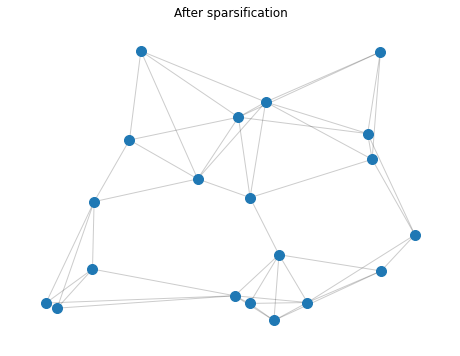

In [42]:
G = nx.from_numpy_array(1-test_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(test_example['nodes'])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
plt.title('After sparsification')
plt.axis('off')
plt.show()

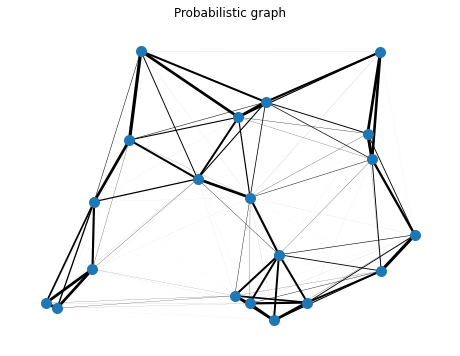

In [43]:
G = nx.from_numpy_array(proba_adj)
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(test_example['nodes'])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=[(G[u][v]['weight']*2)**2 for u,v in G.edges])
plt.title('Probabilistic graph')
plt.axis('off')
plt.show()

Generate a tour

In [44]:
with torch.no_grad():
    _, _, tour = model.forward(nodes, graph, return_pi=True)
tour = tour.cpu().numpy()[0]
tour = np.append(tour, tour[0])
tour

array([ 0, 16, 17, 13,  5, 10, 18,  8,  6,  3, 19, 14,  4, 15,  9,  1, 12,
        7,  2, 11,  0])

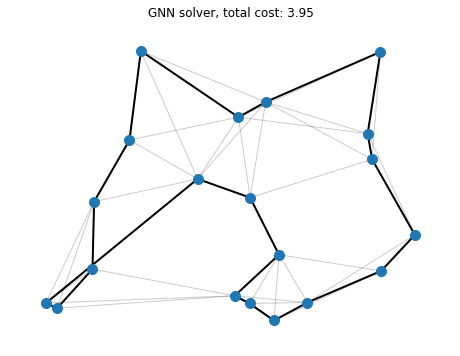

In [45]:
G = nx.from_numpy_array(1-test_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([tour[:-1], tour[1:]], axis=1))
cost = dist_matrix[tour[:-1], tour[1:]].sum()
plt.title(f'GNN solver, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Also check NN heuristic

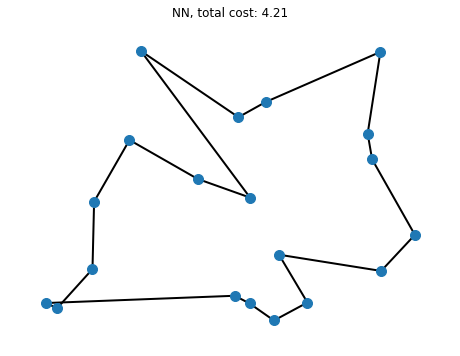

In [46]:
row_id, col_id = nn(dist_matrix)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([row_id, col_id], axis=1), )
cost = dist_matrix[row_id, col_id].sum()
plt.title(f'NN, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

2-OPT

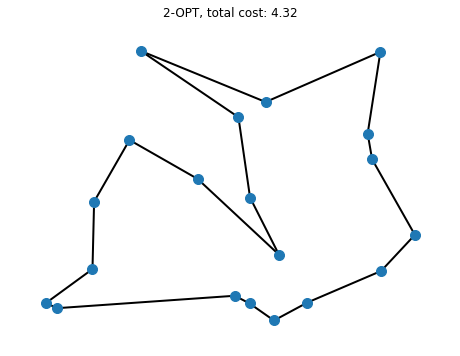

In [47]:
rtour = np.random.permutation(range(dist_matrix.shape[0]))
rtour = np.append(rtour, rtour[0])
row_id, col_id = twoopt(dist_matrix, rtour, n_iter=2)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([row_id, col_id], axis=1), )
cost = dist_matrix[row_id, col_id].sum()
plt.title(f'2-OPT, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Stochastic NN + 2-OPT

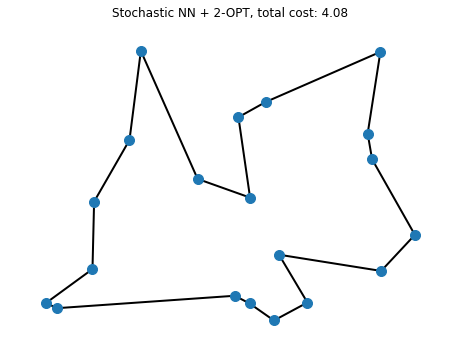

In [48]:
row_id, col_id = stochastic_nn_2opt(dist_matrix, n_iter=5)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([row_id, col_id], axis=1), )
cost = dist_matrix[row_id, col_id].sum()
plt.title(f'Stochastic NN + 2-OPT, total cost: {cost:.2f}')
plt.axis('off')
plt.show()